# Introduction to Support Vector Machines
*Notebook produced by Ethan Trentin*

Loading of the packages used during the session.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## Exercice I. Introduction to C-SVM
 For illustrating kernel methods in general and for Support Vector Machines in particular, we consider a very
 simple classification problem. Let assume that the data is describe in a 1D space divided into two classes (+1
 and −1) as follows:
 $S =\{(x_1 =1,y_1 = 1),(x_2 = 2,y_2 = 1),(x_3 = 4,y_3 = −1),(x_4 = 5,y_4 = −1),(x_5 = 6,y_5 = 1)\}$.
 The following script is used for visualizing the data :

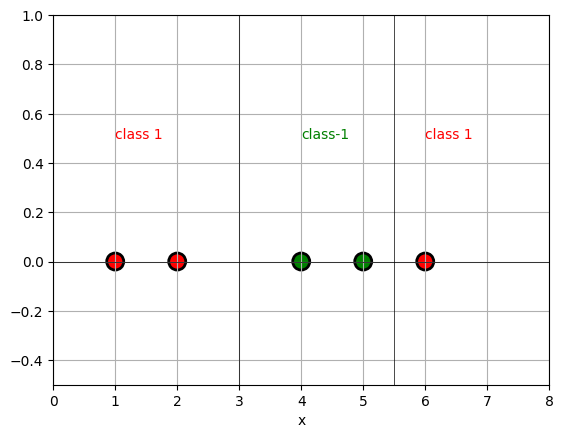

In [3]:
#First, let's visualize the data we have.
x = np.array([1, 2, 4, 5, 6])
class_labels = np.array([1, 1, 2, 2, 1])

# Plotting points
plt.scatter(x, np.zeros_like(x), marker='o', s=150, linewidths=2,
            facecolors=np.array(["red", "green"])[class_labels-1],
            edgecolors='black')

# Adding text labels
text_positions = np.array([[1, 0.5],
                           [4, 0.5],
                           [6, 0.5]])
text_labels = ["class 1", "class-1", "class 1"]
text_colors = np.array(["red", "green", "red"])
for pos, label, color in zip(text_positions, text_labels, text_colors):
    plt.text(pos[0], pos[1], label, color=color)

# Adding gridlines and axes
plt.grid(True)
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.axvline(3, color='black', linestyle='-', linewidth=0.5)
plt.axvline(5.5, color='black', linestyle='-', linewidth=0.5)

# Setting plot limits and labels
plt.xlim(0, 8)
plt.ylim(-0.5, 1)
plt.xlabel('x')
plt.ylabel('')
plt.xticks(rotation=0)

# Displaying the plot
plt.show()

Of course, linear boundary can’t discriminate the two classes and we propose to train a nonlinear SVM classifier combined with a second order polynomial kernel defined as : $k(x_1,x_2) = (x_1^⊤x_2 +1)^2$.

##### Question 1 :
A general C-SVM problem has for primal problem the follwing expression : $ \alpha^* = arg min_{f \in \textit{H}_k} \{C \sum_{i=1}^n \phi_{Hinge}(y_if(x_i)) + \frac{1}{2} ||f||_{\textit{H}_k}^2\}$.

The corresponding dual problem is therefore : $\mu^* = arg max_{0 \le \mu \le C} \{\mu^T1-\frac{1}{2}\mu^Tdiag(y)Kdiag(y)\mu\}$ under the constraint $\mu^Ty=0$.

In our case, the dual problem associated with this SVM optimization problem is therefore :

$\mu^* = arg max_{0 \le \mu \le C} \{\sum_{i=1}^5 \mu_i-\frac{1}{2}\sum_{i=1}^5 \sum_{j=1}^5 \mu_i\mu_jy_iy_j(x_i^Tx_j+1)^2\}$ under the constraint $\sum_{i=1}^5\mu_iy_i=0$.

##### Question 2 and 3 :

In [15]:
x = np.array([1, 2, 4, 5, 6])        # Features
y = np.array([1, 1, -1, -1, 1])      # Labels
C = 100                              # Regularization parameter
n = len(x)

# Polynomial kernel: (x_i^T x_j + 1)^2
def polynomial_kernel(x1, x2):
    return (np.dot(x1, x2) + 1) ** 2

# Kernel matrix K
K = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K[i, j] = polynomial_kernel(x[i], x[j])

# Objective function to minimize (-dual formulation)
def objective(mu):
    # First term : 1/2 sum_i sum_j mu_i mu_j y_i y_j k(x_i, x_j)
    mu_term = 0.5 * np.dot(mu, np.dot(K * (y[:, None] * y[None, :]), mu))
    # Second term : -sum_i alpha_i
    linear_term = -np.sum(mu)
    return mu_term + linear_term

# Equality constraint: sum(mu_i * y_i) = 0
def equality_constraint(mu):
    return np.dot(mu, y)

# Bounds for mu: 0 <= mu_i <= C
bounds = [(0, C) for _ in range(n)]

# Initial guess for mu (starting at 0)
initial_mu = np.zeros(n)

# Solving the quadratic programming problem
result = minimize(objective, initial_mu, bounds=bounds, constraints={'type': 'eq', 'fun': equality_constraint}, method='SLSQP')
# The method is Sequential Least Squares Programming

# The optimized mus
mus = result.x

# Let's print the Lagrange multipliers (mus)
print("Optimized mus:", mus)

Optimized mus: [0.         2.49999042 0.         7.33328341 4.83329299]


Therefore, we get that : $$\hat{\mu}_1 = 0, \hat{\mu}_2 = 2.5, \hat{\mu}_3=0, \hat{\mu}_4=7.333, \hat{\mu}_5=4.833$$

##### Question 4 :

From the representer theorem, we have the following result :

$f(x) = \sum_{i=1}^5 \mu_iy_ik(x,x_i) + b^* = \sum_{i=1}^5 \mu_iy_i(xx_i+1)^2 + b^*$
$f(x) = x^2\sum_{i=1}^5 \mu_iy_ix_i^2 + x(2\sum_{i=1}^5 \mu_iy_ix_i) + (\sum_{i=1}^5 \mu_iy_i + b^*)$

So, we have :

$w_0 = \sum_{i=1}^5 \mu_iy_i + b^* = b^*$ as the constraint $\mu^Ty=0$

and $y_if(x_i) = 1$ for any Support Vector $x_i$. It means that $y_i(\sum_{j=1}^5 \mu_jy_jk(x_i,x_j) + b^*) = 1$, or $b^* = \frac{1-y_i\sum_{j=1}^5 \mu_jy_jk(x_i,x_j)}{y_i}$. For example, we can use the first couple of observations to compute this result : $x_1 = 1, y_1 = 1$. It gives $b^* = 1-\sum_{j=1}^5 \mu_jy_jk(1,x_j) = 1-\sum_{j=1}^5 \mu_jy_j(x_j+1)^2$. Therefore :

$w_0 = 1-\sum_{j=1}^5 \mu_jy_j(x_j+1)^2$

$w_1 = 2\sum_{i=1}^5 \mu_iy_ix_i$

$w_2 = \sum_{i=1}^5 \mu_iy_ix_i^2$

##### Question 5 :

The values of the coefficients are w_0 :  9.000231115357488 , w_1 :  -5.333441805121424 , w_2 :  0.666677694161649


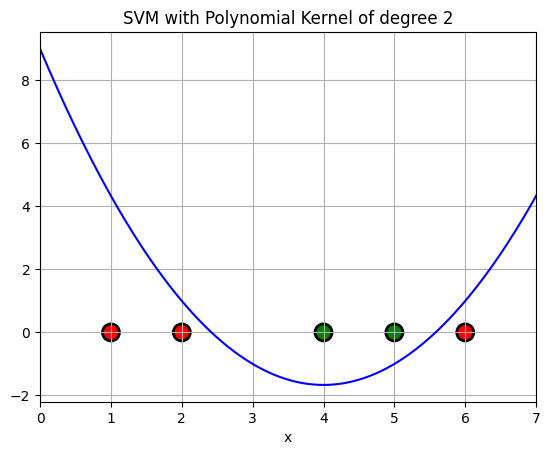

In [12]:
w_2 = 0
w_1 = 0
w_0_2 = 0
w_0_5 = 0
w_0_6 = 0
for i in range(len(x)):
    w_0_2 += mus[i]*y[i]*(2*x[i]+1)**2
    w_0_5 += mus[i]*y[i]*(5*x[i]+1)**2
    w_0_6 += mus[i]*y[i]*(6*x[i]+1)**2
    w_1 += mus[i]*y[i]*x[i]
    w_2 += mus[i]*y[i]*(x[i])**2
w_1 = 2*w_1
w_0_2 = 1-w_0_2
w_0_5 = -1-w_0_5
w_0_6 = 1-w_0_6
w_0 = (w_0_2+ w_0_5+ w_0_6)/3
print("The values of the coefficients are w_0 : ", w_0, ", w_1 : ", w_1, ", w_2 : ", w_2)

x_ref = np.linspace(0,8,200)
optimal_function = [w_2*x_ref_i**2 + w_1*x_ref_i + w_0 for x_ref_i in x_ref]

plt.scatter(x, np.zeros_like(x), marker='o', s=150, linewidths=2,
            facecolors=np.array(["red", "green"])[class_labels-1],
            edgecolors='black')
plt.plot(x_ref, optimal_function, "-b")
plt.grid(True)
plt.xlim(0, 7)
plt.xlabel('x')
plt.title('SVM with Polynomial Kernel of degree 2')
plt.xticks(rotation=0)
plt.show()


Support vectors: [2 5 6]
Bias (b): 9.005359411794188


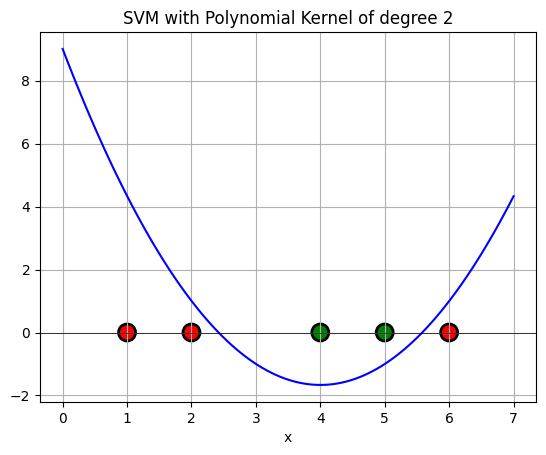

In [17]:
#We could have computed the decision function f using the polynomial kernel values. The following script gives the same result as the one upper :

support_vector_indices = np.where((mus > 1e-5) & (mus < C))[0]
support_vectors = x[support_vector_indices]
print("Support vectors:", support_vectors)

# Calculate bias b
b_values = []
for i in support_vector_indices:
    # f(x_i) = sum(mu_j * y_j * K(x_j, x_i)) + b should equal y_i for support vectors
    b_values.append(y[i] - np.sum(mus * y * K[:, i]))

# Average b over all support vectors
b = np.mean(b_values)
print("Bias (b):", b)

# Decision function using the polynomial kernel
def decision_function(x_new):
    # Compute the decision function f(x) = sum(mu_i * y_i * K(x_i, x_new)) + b
    kernel_values = np.array([polynomial_kernel(xi, x_new) for xi in x])
    return np.sum(mus * y * kernel_values) + b

plt.scatter(x, np.zeros(n), marker='o', s=150, linewidths=2,
            facecolors=np.array(["red", "green"])[class_labels-1],
            edgecolors='black')

x_range = np.linspace(min(x)-1, max(x)+1, C)
decision_boundary = [decision_function(xi) for xi in x_range]
plt.plot(x_range, decision_boundary, 'b-', label='Decision boundary')

plt.grid(True)
plt.title('SVM with Polynomial Kernel of degree 2')
plt.xlabel('x')
plt.axhline(0, color='black',linewidth=0.5)
plt.show()


### Exercice II. Support Vector Machines and cross validation

In this exercise, we study the checkerboard smiluated data set.

#### Question 1 :    

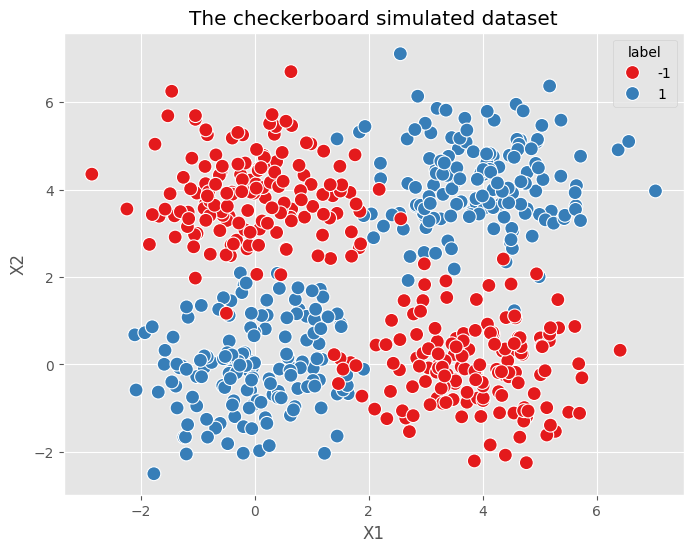

In [73]:
# Let's define the function to generate the dataset
def GenerateDatasetNonlinear(n, p):
    # We generate four clusters using multivariate normal distribution
    bottom_left = np.random.multivariate_normal(mean=[0] * p, cov=np.eye(p), size=n)
    upper_right = np.random.multivariate_normal(mean=[4] * p, cov=np.eye(p), size=n)
    upper_left = np.random.multivariate_normal(mean=[0, 4], cov=np.eye(p), size=n)
    bottom_right = np.random.multivariate_normal(mean=[4, 0], cov=np.eye(p), size=n)

    x = np.vstack((bottom_left, upper_right, upper_left, bottom_right))

    y = np.concatenate([np.ones(2 * n), -1 * np.ones(2 * n)])

    data = pd.DataFrame(x, columns=[f'X{i+1}' for i in range(p)])
    data['y'] = y

    return data

# Generate the dataset
data = GenerateDatasetNonlinear(150, 2)

# Set the plot style to 'ggplot' for grey background, as in R
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['X1'], y=data['X2'], hue=data['y'].astype(int), palette='Set1', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The checkerboard simulated dataset')
plt.legend(title='label')
plt.show()


#### Question 2 :

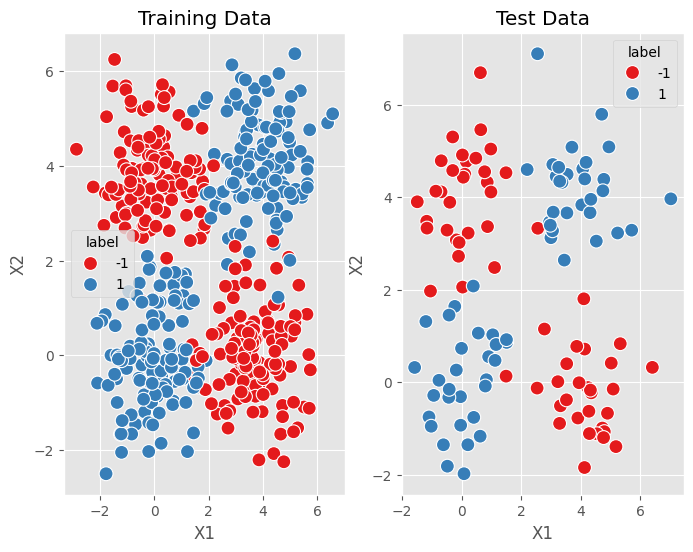

In [74]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['y'])
#By setting stratify=data['y'], the function will split the data while keeping the distribution of the target variable consistent in both the
#training and test sets, just like the function createDataPartition of the caret package in R.

# Plot the training data
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))

# Train set
plt.subplot(1, 2, 1)
sns.scatterplot(x=train_data['X1'], y=train_data['X2'], hue=train_data['y'].astype(int), palette='Set1', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Training Data')
plt.legend(title='label')

# Plot the test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=test_data['X1'], y=test_data['X2'], hue=test_data['y'].astype(int), palette='Set1', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Test Data')
plt.legend(title='label')
plt.show()

#### Question 3 :

In [75]:
# We define the SVM model with a specific kernel (similar to ksvm in kernlab)
sigma = 1
gamma_value = 1 / (2 * sigma**2)

svm_model = SVC(kernel='rbf', C=1.0, gamma=gamma_value)
# We fit the model
svm_model.fit(train_data[['X1','X2']], train_data['y'])

SVC(gamma=0.5)

#### Question 4 :

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


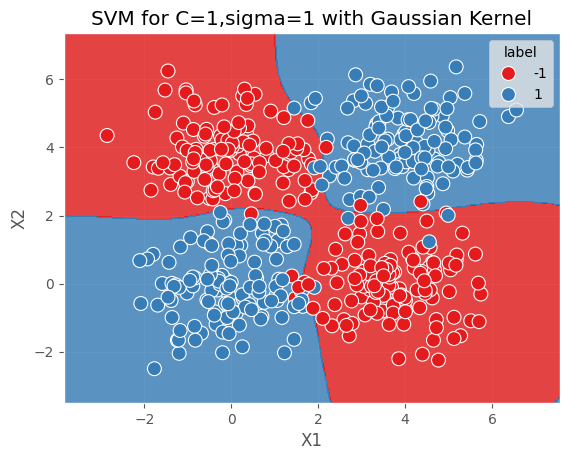

In [76]:
# We are going to create a function in order to plot the decision boundary
def plot_decision_boundary(model,name,X, y):
    h = .02  # step size in the mesh
    X=X.values
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) #it produces two matrixes :
    # one with the x-coordinates repeated for each value in y and one with the y-coordinatesrepeated for each value in x.

    # Predict the decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # We first flatten the matrixes xx and yy into 1D arrays and then combine them
    # into a 2D array used for prediction with the model.
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and data points
    cmap = ListedColormap(sns.color_palette('Set1', n_colors=len(set(y))))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.8)
    # Z represents the "height" or value of the function at each (X, Y) coordinate.
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y.astype(int), palette='Set1', s=100)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f'SVM {name} with Gaussian Kernel')
    plt.legend(title='label')
    plt.show()

# Visualize decision boundary
plot_decision_boundary(svm_model,"for C=1,sigma=1",train_data[['X1','X2']], train_data['y'])

#### Question 5 :

The exponential function of the gaussian Kernel we built our SVM model on is expressed of the form : $k(x,y)=e^{-\sigma \lVert x-y \rVert^2}$.
Therefore, by writing its first-order Taylor approximation, we get : $k(x,y) =_{\sigma \rightarrow 0} 1-\sigma \lVert x-y \rVert ^2$.
So, by replacing the kernel by this approximation in the boundary function, we have the following result : $$\hat{f}(x) = \sum_{i \in SV} \alpha_i^*(1-\sigma \lVert x-x_i \rVert^2)+b^*$$.
By developping the expression, we have : $$\hat{f}(x) = (\sigma\sum_{i \in SV}\alpha_i^*)x^Tx -(2\sigma\sum_{i \in SV} \alpha_i^*x_i^T)x + \sum_{i \in SV} \alpha_i^* + \sum_{i \in SV} \alpha_i^* \sigma x_i^T x_i$$.
The quadratic term in $x$ is equal to 0 as one of the conditions of the dual problem of the SVM is to have ${\mu^*}^Ty=0$. As we have $$\alpha_i^*=\mu^*_iy_i$, then $\sum_{i\in SV} \alpha^*_i={\mu^*}^Ty=0$
So, we finally get : $\hat{f}(x) = -(2\sigma\sum_{i \in SV} \alpha_i^*x_i^T)x + \sum_{i \in SV} \alpha_i^* + \sum_{i \in SV} \alpha_i^* \sigma x_i^T x_i$. So, for small value of $\sigma$, the SVM decision boundary is linear.

#### Question 6 :

The optimal value of C is :  100.0
The optimal value of sigma is :  5.272631578947367


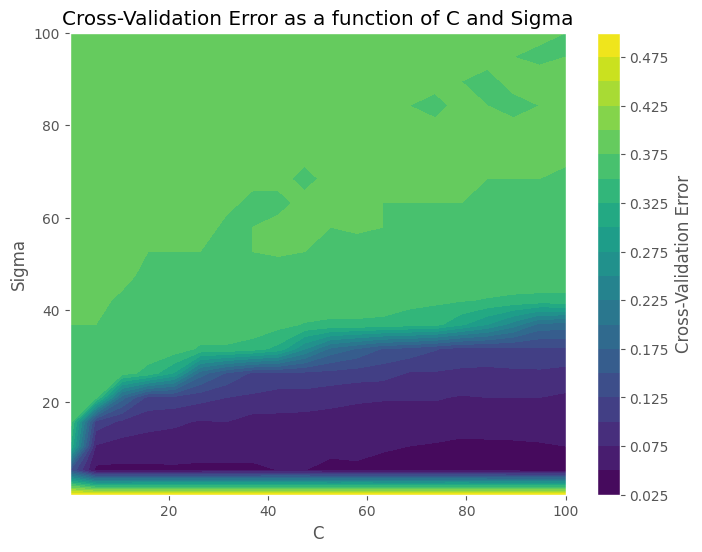

In [77]:
nb_folds = 10
C_values = np.linspace(0.01, 100, 20)
sigma_values = np.linspace(0.01, 100, 20)
gamma_values = 1/(2*sigma_values**2)
svm_model = SVC(kernel='rbf')
svm_param_grid = {"C":C_values,
                  "gamma":gamma_values}

SVM = GridSearchCV(svm_model, cv=nb_folds, param_grid=svm_param_grid)
SVM.fit(train_data[['X1','X2']],train_data['y'])
C_optimal = SVM.best_params_['C']
gamma_optimal = SVM.best_params_['gamma']
sigma_optimal = 1/np.sqrt(2*gamma_optimal)
print("The optimal value of C is : ", C_optimal)
print("The optimal value of sigma is : ", sigma_optimal)
results=SVM.cv_results_
mean_test_errors = 1-np.array(results['mean_test_score']).reshape(len(svm_param_grid['C']), len(svm_param_grid['gamma']))
#The Cross-validation error rate is equal to 1 - Accuracy, where the Accuracy is the number of correct predictions divided by the total number of predictions
gammas=np.array(svm_param_grid['gamma'])
sigmas=1/np.sqrt(2*gammas)
plt.figure(figsize=(8,6))
C_values_bis, sigma_values_bis = np.meshgrid(svm_param_grid['C'],sigmas)
plt.contourf(C_values_bis, sigma_values_bis, mean_test_errors.T, levels=20,cmap='viridis')
plt.colorbar(label='Cross-Validation Error')
plt.xlabel('C')
plt.ylabel('Sigma')
plt.title('Cross-Validation Error as a function of C and Sigma')
plt.show()

#### Question 7 :

Accuracy: 96.6667%
Error rate: 3.3333%


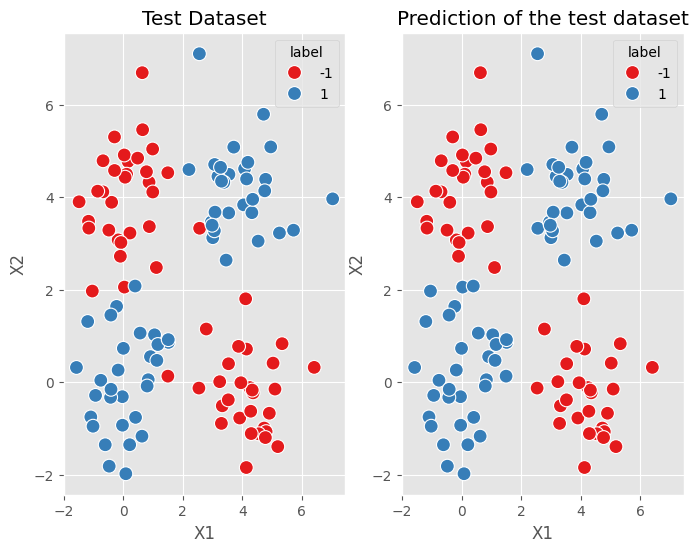

In [78]:
final_svm = SVC(kernel='rbf', C=C_optimal, gamma=gamma_optimal)
final_svm.fit(train_data[['X1','X2']], train_data['y'])
y_test_pred = final_svm.predict(test_data[['X1','X2']])
# We calculate accuracy
test_accuracy = accuracy_score(test_data['y'], y_test_pred)
test_error_rate = 1-test_accuracy
print(f'Accuracy: {test_accuracy * 100:.4f}%')
print(f'Error rate: {test_error_rate * 100:.4f}%')
#We plot the resulting SVM model.
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=test_data['X1'], y=test_data['X2'], hue=test_data['y'].astype(int), palette='Set1', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Test Dataset')
plt.legend(title='label')
plt.subplot(1, 2, 2)
sns.scatterplot(x=test_data['X1'], y=test_data['X2'], hue=y_test_pred.astype(int), palette='Set1', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Prediction of the test dataset')
plt.legend(title='label')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


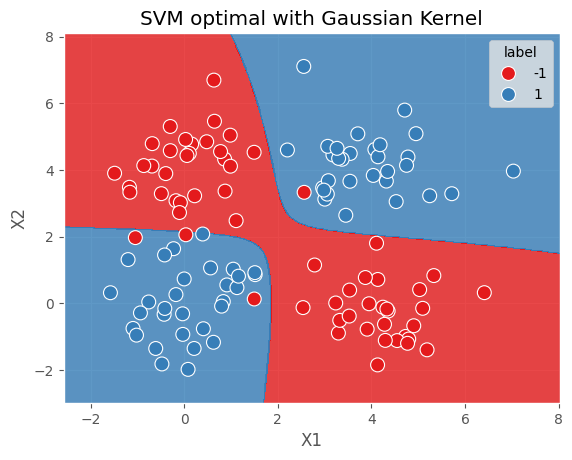

In [79]:
#Let's new plot the optimal
plot_decision_boundary(final_svm,"optimal", test_data[['X1','X2']], test_data['y'])

### Exercise III : Alzheimer or not ?

#### Question 1 :

In [2]:
Alzheimer_data = pd.read_table('Alzheimer_Webster.txt', sep=' ')
#We can see that the dataset has 364 lines, one for each individual : 188 controls versus 176 patients.
Alzheimer_data

,GI_10047091-S,GI_10047093-S,GI_10047103-S,GI_10047133-A,GI_10092596-S,GI_10092600-S,GI_10092616-S,GI_10092618-S,GI_10092672-S,GI_10190705-S,...,GI_9966826-S,GI_9966840-S,GI_9966848-S,GI_9966856-S,GI_9966874-A,GI_9966880-S,GI_9966896-S,GI_9966902-S,GI_9994168-S,Y
WGACON.219,10223.2,131.0,1853.7,72.300000,187.6,1765.2,165.0,649.9,273.2,152.3,...,319.1,82.0,45.0,209.1,217.2,25.5,211.9,364.8,61.7,0
WGACON.221,7306.5,85.4,1294.5,195.600000,173.6,754.7,84.1,580.8,220.0,168.6,...,557.4,74.6,51.3,188.7,393.4,57.9,106.7,273.0,80.1,0
WGACON.234,4644.5,212.8,1286.5,28.300000,330.7,845.7,1253.6,415.2,183.1,457.3,...,539.4,34.7,62.0,209.6,83.4,98.0,163.4,257.6,103.3,0
WGACON.274,5679.0,115.7,1009.1,106.400000,403.0,579.9,222.1,249.5,239.0,62.6,...,530.8,49.7,39.2,186.9,130.4,74.3,133.2,292.3,99.7,0
WGACON.277,5648.3,124.8,982.0,145.200000,360.5,905.1,73.5,364.2,241.0,130.8,...,693.3,101.8,53.9,186.6,235.3,73.1,81.3,385.4,93.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WGAAD.69,3700.3,123.8,1102.5,75.600000,246.0,1321.6,240.2,731.7,146.6,195.1,...,418.4,56.6,64.7,210.0,232.7,39.7,180.0,240.7,120.4,1
WGAAD.45,2673.4,125.1,1044.1,65.400000,203.3,963.8,281.1,692.6,132.6,228.0,...,436.9,72.9,40.7,190.1,157.2,91.3,178.8,548.9,186.6,1
WGAAD.89,3877.5,192.2,1260.5,92.700000,146.2,1261.3,314.5,959.2,112.3,164.3,...,471.2,64.3,61.2,184.4,272.0,60.4,155.1,366.8,152.3,1
WGAAD.391,4029.4,219.3,1636.5,29.400000,316.5,340.7,634.5,1197.2,297.7,368.9,...,699.3,58.2,53.4,247.5,82.9,152.4,256.0,220.2,30.3,1


In [3]:
Alzheimer_data.columns

Index(['GI_10047091-S', 'GI_10047093-S', 'GI_10047103-S', 'GI_10047133-A',
       'GI_10092596-S', 'GI_10092600-S', 'GI_10092616-S', 'GI_10092618-S',
       'GI_10092672-S', 'GI_10190705-S',
       ...
       'GI_9966826-S', 'GI_9966840-S', 'GI_9966848-S', 'GI_9966856-S',
       'GI_9966874-A', 'GI_9966880-S', 'GI_9966896-S', 'GI_9966902-S',
       'GI_9994168-S', 'Y'],
      dtype='object', length=8651)

In [3]:
nb_patients = Alzheimer_data[Alzheimer_data['Y']==1].shape[0] # Number of people with Alzheimer's disease.
nb_controls = Alzheimer_data[Alzheimer_data['Y']==0].shape[0] # Number of people without Alzheimer's disease.
print("The number of patients with Alzheimer disease is :", nb_patients)
print("The number of patients without Alzheimer disease is :", nb_controls)

The number of patients with Alzheimer disease is : 176
The number of patients without Alzheimer disease is : 188


In [4]:
Alzheimer_train_data, Alzheimer_test_data = train_test_split(Alzheimer_data, test_size=0.2, random_state=42, stratify=Alzheimer_data['Y'])

The optimal value of C is :  0.00021544346900318823
The optimal corresponding score is :  0.9037931034482758


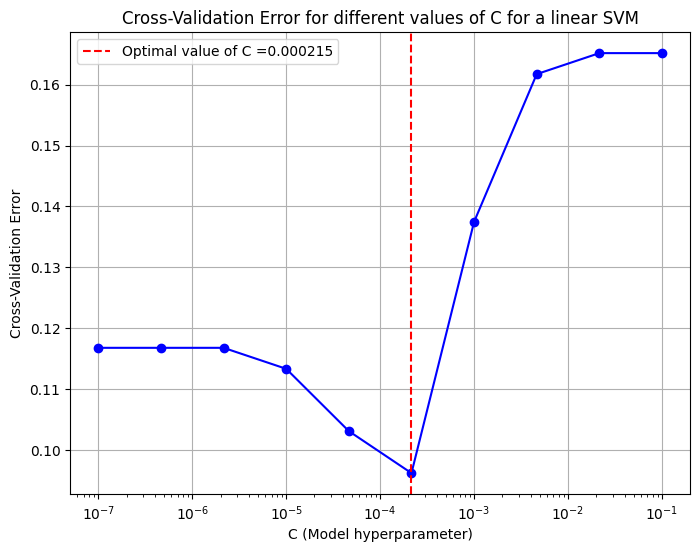

In [5]:
nb_folds = 10
C_values = np.logspace(-7, -1, 10)
svm_model = SVC(kernel='linear')
svm_param_grid = {"C":C_values}

SVM = GridSearchCV(svm_model, cv=nb_folds, param_grid=svm_param_grid)
SVM.fit(Alzheimer_train_data.iloc[:,:-1],Alzheimer_train_data['Y'])

C_optimal = SVM.best_params_['C']
print("The optimal value of C is : ", C_optimal)
Score_optimal = SVM.best_score_
print("The optimal corresponding score is : ", Score_optimal)

results=SVM.cv_results_
mean_test_errors = 1-np.array(results['mean_test_score'])
param_C_values = SVM.cv_results_['param_C'].data
plt.figure(figsize=(8,6))
plt.plot(param_C_values, mean_test_errors, 'o-', color ='b')
plt.xscale('log')
plt.title('Cross-Validation Error for different values of C for a linear SVM')
plt.xlabel('C (Model hyperparameter)')
plt.ylabel('Cross-Validation Error')
plt.grid(True)
plt.axvline(x=C_optimal, color='r', linestyle='--', label=f'Optimal value of C ={round(C_optimal,6)}')
plt.legend()
plt.show()

In [6]:
final_svm = SVC(kernel='linear', C=C_optimal)
final_svm.fit(Alzheimer_train_data.iloc[:,:-1],Alzheimer_train_data['Y'])
y_test_pred = final_svm.predict(Alzheimer_test_data.iloc[:,:-1])
# We calculate accuracy
test_accuracy = accuracy_score(Alzheimer_test_data['Y'], y_test_pred)
test_error_rate = 1-test_accuracy
print(f'Accuracy: {test_accuracy * 100:.4f}%')
print(f'Error rate: {test_error_rate * 100:.4f}%')

Accuracy: 86.3014%
Error rate: 13.6986%


In [7]:
len(y_test_pred)

73

In [8]:
final_dataframe = Alzheimer_test_data.iloc[:,-1].to_frame()
final_dataframe['Y_pred'] = y_test_pred
final_dataframe

,Y,Y_pred
WGACON.261,0,0
WGAAD.389,1,1
WGACON.251,0,0
WGACON.40,0,0
WGAAD.394,1,1
...,...,...
WGACON.190,0,1
WGACON.254,0,0
WGACON.57,0,0
WGAAD.61,1,1


In [9]:
filtered_dataframe = final_dataframe[final_dataframe['Y']!=final_dataframe['Y_pred']]
filtered_dataframe

,Y,Y_pred
WGAAD.186,1,0
WGAAD.144,1,0
WGAAD.330,1,0
WGACON.30,0,1
WGACON.141,0,1
WGACON.83,0,1
WGAAD.158,1,0
WGAAD.476,1,0
WGAAD.379,1,0
WGACON.190,0,1


#### Question 2 :

Confusion Matrix:
[[34  4]
 [ 6 29]]

Classification Report:
              precision    recall  f1-score   support

     Control       0.85      0.89      0.87        38
   Alzheimer       0.88      0.83      0.85        35

    accuracy                           0.86        73
   macro avg       0.86      0.86      0.86        73
weighted avg       0.86      0.86      0.86        73



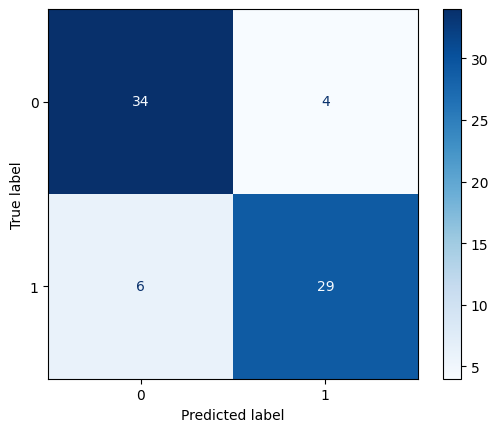

In [11]:
#Let's generate the confusion matrix and the report to qualify the quality of the model.
conf_matrix = confusion_matrix(Alzheimer_test_data['Y'], y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Display the confusion matrix visually
ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues")

# Generate classification metrics
report = classification_report(Alzheimer_test_data['Y'], y_test_pred, target_names=['Control', 'Alzheimer'])
print("\nClassification Report:")
print(report)


We can see that the confusion matrix prints the true label in function of the predicted label, and displays the numbers of individual in each category, according to their predicted and their true label. With this, we can calculate the True Positive Rate (or the recall), the True Negative Rate, The False Positive Rate, the False Negative Rate, the precision and the accuracy.

Some of those metrics are displayed in the classification report printed.
- We can see that the Recall for Control individuals is equal to 0.89 ($=\frac{True Positive}{True Positive+False Negative}=\frac{34}{34+4}$), while the Recall for Alzheimer individuals is equal to 0.83 ($=\frac{True Positive}{True Positive+False Negative}=\frac{29}{29+6}$).
- The Precision is calculated by dividing the True positive by the Predicted Positive (True Positive + False Positive). For the Control individuals it gives : $\frac{34}{34+6}=0.85$ and for the Alzheimer individuals it returns : $\frac{29}{29+4}=0.88$.
- The F1-score is calculated by using the following formula : $2\frac{Precision*Recall}{Precision+Recall}$, so the harmonic mean of precision and recall. For the Control individuals, this returns $2\frac{0.89*0.85}{0.89+0.85}=0.87$ and for the alzheimer individuals, it gives : $2\frac{0.83*0.88}{0.83+0.88}=0.85$
- Finally the accuracy is again displayed and can be recalculated by $\frac{True Negative + True Positive}{Negative + Positive}=\frac{29+34}{40+33}=0.86$.

For a SVM model with medical applications, this accuracy is a bit too small. The error needs indeed to be the closest to 0% possible, even more as Alzheimer is a life's threatening disease. Moreover, when considering the event "Being healthy without Alzheimer" we have more false negative than false positive, as 4 healthy people are predicted to be sick while 6 sick people are predicted to be healthy. This can be dangerous as medical predictions tend to prefer false positive than false negative, even if a false diagnostic of an healthy person can lead to unecessary stress in the beginning.

Let's try other kernels to see if we can improve the model.

#### Bonus :

Let's try to model using Gaussian Kernels and Polynomial Kernels.

The optimal value of C is :  464.15888336127773
The optimal corresponding score is :  0.8864367816091955


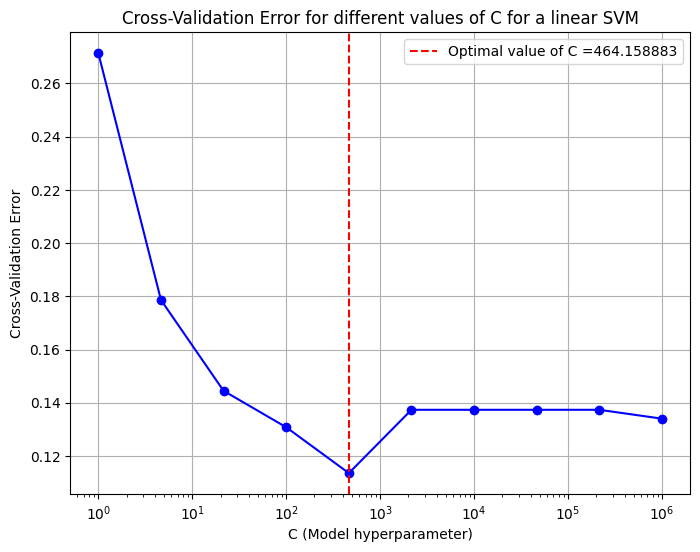

In [12]:
nb_folds = 10
C_values = np.logspace(0, 6, 10)
svm_model_2 = SVC(kernel='poly', degree=2)
svm_param_grid = {"C":C_values}

SVM_2 = GridSearchCV(svm_model_2, cv=nb_folds, param_grid=svm_param_grid)
SVM_2.fit(Alzheimer_train_data.iloc[:,:-1],Alzheimer_train_data['Y'])

C_optimal = SVM_2.best_params_['C']
print("The optimal value of C is : ", C_optimal)
Score_optimal = SVM_2.best_score_
print("The optimal corresponding score is : ", Score_optimal)

results=SVM_2.cv_results_
mean_test_errors = 1-np.array(results['mean_test_score'])
param_C_values = SVM_2.cv_results_['param_C'].data
plt.figure(figsize=(8,6))
plt.plot(param_C_values, mean_test_errors, 'o-', color ='b')
plt.xscale('log')
plt.title('Cross-Validation Error for different values of C for a linear SVM')
plt.xlabel('C (Model hyperparameter)')
plt.ylabel('Cross-Validation Error')
plt.grid(True)
plt.axvline(x=C_optimal, color='r', linestyle='--', label=f'Optimal value of C ={round(C_optimal,6)}')
plt.legend()
plt.show()

In [13]:
final_svm_2 = SVC(kernel='poly', degree=2, C=C_optimal)
final_svm_2.fit(Alzheimer_train_data.iloc[:,:-1],Alzheimer_train_data['Y'])
y_test_pred_2 = final_svm_2.predict(Alzheimer_test_data.iloc[:,:-1])
# We calculate accuracy
test_accuracy = accuracy_score(Alzheimer_test_data['Y'], y_test_pred_2)
test_error_rate = 1-test_accuracy
print(f'Accuracy: {test_accuracy * 100:.4f}%')
print(f'Error rate: {test_error_rate * 100:.4f}%')

Accuracy: 84.9315%
Error rate: 15.0685%


Therefore this model is still a bit less powerful than the linear one. Let's try with a deegree 3 polynomial kernel.

The optimal value of C is :  2154434.6900318824
The optimal corresponding score is :  0.8760919540229886


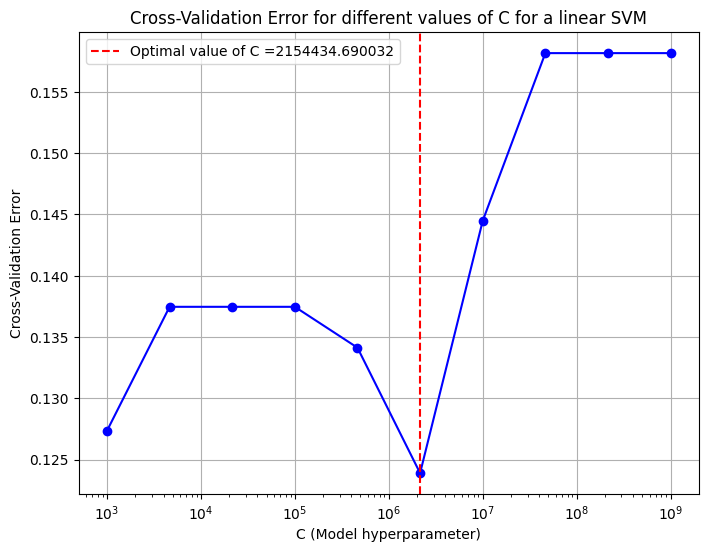

In [14]:
nb_folds = 10
C_values = np.logspace(3, 9, 10)
svm_model_3 = SVC(kernel='poly', degree=3)
svm_param_grid = {"C":C_values}

SVM_3 = GridSearchCV(svm_model_3, cv=nb_folds, param_grid=svm_param_grid)
SVM_3.fit(Alzheimer_train_data.iloc[:,:-1],Alzheimer_train_data['Y'])

C_optimal = SVM_3.best_params_['C']
print("The optimal value of C is : ", C_optimal)
Score_optimal = SVM_3.best_score_
print("The optimal corresponding score is : ", Score_optimal)

results=SVM_3.cv_results_
mean_test_errors = 1-np.array(results['mean_test_score'])
param_C_values = SVM_3.cv_results_['param_C'].data
plt.figure(figsize=(8,6))
plt.plot(param_C_values, mean_test_errors, 'o-', color ='b')
plt.xscale('log')
plt.title('Cross-Validation Error for different values of C for a linear SVM')
plt.xlabel('C (Model hyperparameter)')
plt.ylabel('Cross-Validation Error')
plt.grid(True)
plt.axvline(x=C_optimal, color='r', linestyle='--', label=f'Optimal value of C ={round(C_optimal,6)}')
plt.legend()
plt.show()

In [15]:
final_svm_3 = SVC(kernel='poly', degree=3, C=C_optimal)
final_svm_3.fit(Alzheimer_train_data.iloc[:,:-1],Alzheimer_train_data['Y'])
y_test_pred_3 = final_svm_3.predict(Alzheimer_test_data.iloc[:,:-1])
# We calculate accuracy
test_accuracy = accuracy_score(Alzheimer_test_data['Y'], y_test_pred_3)
test_error_rate = 1-test_accuracy
print(f'Accuracy: {test_accuracy * 100:.4f}%')
print(f'Error rate: {test_error_rate * 100:.4f}%')

Accuracy: 82.1918%
Error rate: 17.8082%


The model is even worse here with a larger error rate. We can finally try the Gaussian Kernels.

The optimal value of C is :  1e-15
The optimal value of sigma is :  1e-15
The optimal corresponding score is :  0.5155172413793105


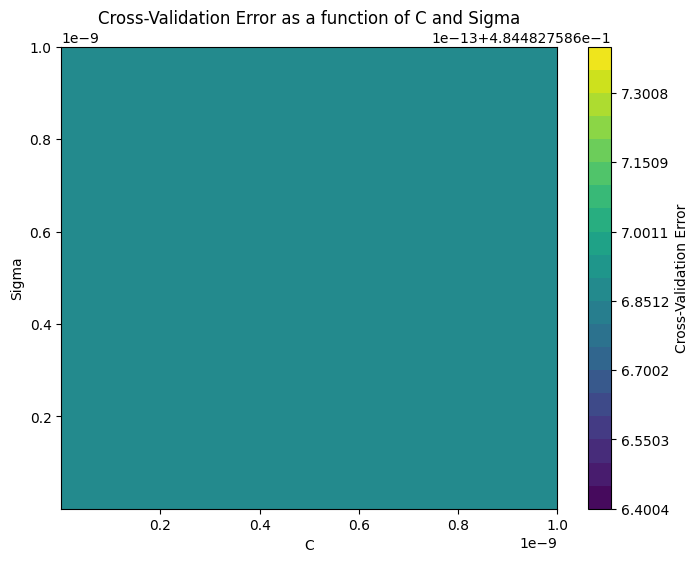

In [18]:
nb_folds = 10
C_values = np.logspace(-15, -9, 10)
sigma_values = np.logspace(-15, -9, 10)
gamma_values = 1/(2*sigma_values**2)
svm_model_4 = SVC(kernel='rbf')
svm_param_grid = {"C":C_values,
                  "gamma":gamma_values}

SVM_4 = GridSearchCV(svm_model_4, cv=nb_folds, param_grid=svm_param_grid)
SVM_4.fit(Alzheimer_train_data.iloc[:,:-1],Alzheimer_train_data['Y'])

C_optimal = SVM_4.best_params_['C']
gamma_optimal = SVM_4.best_params_['gamma']
sigma_optimal = 1/np.sqrt(2*gamma_optimal)
print("The optimal value of C is : ", C_optimal)
print("The optimal value of sigma is : ", sigma_optimal)
Score_optimal = SVM_4.best_score_
print("The optimal corresponding score is : ", Score_optimal)

results=SVM_4.cv_results_
mean_test_errors = 1-np.array(results['mean_test_score']).reshape(len(svm_param_grid['C']), len(svm_param_grid['gamma']))
#The Cross-validation error rate is equal to 1 - Accuracy, where the Accuracy is the number of correct predictions divided by the total number of predictions
gammas=np.array(svm_param_grid['gamma'])
sigmas=1/np.sqrt(2*gammas)
plt.figure(figsize=(8,6))
C_values_bis, sigma_values_bis = np.meshgrid(svm_param_grid['C'],sigmas)
plt.contourf(C_values_bis, sigma_values_bis, mean_test_errors.T, levels=20,cmap='viridis')
plt.colorbar(label='Cross-Validation Error')
plt.xlabel('C')
plt.ylabel('Sigma')
plt.title('Cross-Validation Error as a function of C and Sigma')
plt.show()

In [17]:
final_svm_4 = SVC(kernel='rbf', C=C_optimal, gamma=gamma_optimal)
final_svm_4.fit(Alzheimer_train_data.iloc[:,:-1],Alzheimer_train_data['Y'])
y_test_pred_4 = final_svm_4.predict(Alzheimer_test_data.iloc[:,:-1])
# We calculate accuracy
test_accuracy = accuracy_score(Alzheimer_test_data['Y'], y_test_pred_4)
test_error_rate = 1-test_accuracy
print(f'Accuracy: {test_accuracy * 100:.4f}%')
print(f'Error rate: {test_error_rate * 100:.4f}%')

Accuracy: 52.0548%
Error rate: 47.9452%


With Gaussian Kernels, I tested for values of C and sigma going from $10^3$ to $10^{-15}$ and I still couldn't find a proper optimal solution. Therefore, this model seems to be insufficient to model our problem.
Other complex Kernels could be tried for this problem but it seems that the linear one fits the best.